# 1. Import Dependencies

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error as mse
import math

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
data = pd.read_excel(r'C:\Users\Rohit\Desktop\Data Science Projects\Deep Learning Case Studies\DL Exam\Datasets_20211017T093007Z_001\Datasets\LSTM\Sales Forecasting_Train Data.xlsx')
data.head()

,HQ,Country,State_of_outlet,City_of_outlet,Month,Day,Year,Total_Sales
0,Asia,India,NaN,Bombay (Mumbai),1,1,2005,72.2
1,Asia,India,NaN,Bombay (Mumbai),1,2,2005,72.7
2,Asia,India,NaN,Bombay (Mumbai),1,3,2005,74.3
3,Asia,India,NaN,Bombay (Mumbai),1,4,2005,78.9
4,Asia,India,NaN,Bombay (Mumbai),1,5,2005,81.5


In [23]:
print(data.shape)
data.info()

(17536, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17536 entries, 0 to 17535
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   HQ               17536 non-null  object 
 1   Country          17536 non-null  object 
 2   State_of_outlet  0 non-null      float64
 3   City_of_outlet   17536 non-null  object 
 4   Month            17536 non-null  int64  
 5   Day              17536 non-null  int64  
 6   Year             17536 non-null  int64  
 7   Total_Sales      17536 non-null  float64
dtypes: float64(2), int64(3), object(3)
memory usage: 1.1+ MB


In [24]:
data.describe()

,State_of_outlet,Month,Day,Year,Total_Sales
count,0.0,17536.000000,17536.000000,17536.000000,17536.000000
mean,NaN,6.524179,15.732892,2010.502053,80.117963
std,NaN,3.449400,8.801978,3.452525,13.315486
min,NaN,1.000000,1.000000,2005.000000,-99.000000
25%,NaN,4.000000,8.000000,2008.000000,77.500000
50%,NaN,7.000000,16.000000,2011.000000,82.600000
75%,NaN,10.000000,23.000000,2014.000000,86.100000
max,NaN,12.000000,31.000000,2016.000000,102.500000


# 2. Exploratory Data Analysis

In [25]:
data.isnull().sum()/data.isnull().count()*100

HQ                   0.0
Country              0.0
State_of_outlet    100.0
City_of_outlet       0.0
Month                0.0
Day                  0.0
Year                 0.0
Total_Sales          0.0
dtype: float64

State_of_outlet feature is completely null so i will drop the whole feature.

In [26]:
data.drop('State_of_outlet', axis=1, inplace=True)
data.head()

,HQ,Country,City_of_outlet,Month,Day,Year,Total_Sales
0,Asia,India,Bombay (Mumbai),1,1,2005,72.2
1,Asia,India,Bombay (Mumbai),1,2,2005,72.7
2,Asia,India,Bombay (Mumbai),1,3,2005,74.3
3,Asia,India,Bombay (Mumbai),1,4,2005,78.9
4,Asia,India,Bombay (Mumbai),1,5,2005,81.5


In [27]:
data.nunique()

HQ                  1
Country             1
City_of_outlet      4
Month              12
Day                31
Year               12
Total_Sales       539
dtype: int64

#### "HQ" and "Country" feature have only one unique value that means they both contain similar values individually so I will drop those two features too.

In [28]:
data.drop(['HQ', 'Country'], axis=1, inplace=True)
data.head()

,City_of_outlet,Month,Day,Year,Total_Sales
0,Bombay (Mumbai),1,1,2005,72.2
1,Bombay (Mumbai),1,2,2005,72.7
2,Bombay (Mumbai),1,3,2005,74.3
3,Bombay (Mumbai),1,4,2005,78.9
4,Bombay (Mumbai),1,5,2005,81.5


# 3. Feature Engineering

In [29]:
data['Date'] = data.Year.map(str)+'-'+data.Month.map(str)+'-'+data.Day.map(str)
data['Date']

0          2005-1-1
1          2005-1-2
2          2005-1-3
3          2005-1-4
4          2005-1-5
            ...    
17531    2016-12-27
17532    2016-12-28
17533    2016-12-29
17534    2016-12-30
17535    2016-12-31
Name: Date, Length: 17536, dtype: object

In [30]:
data['Month'] = data['Month'].astype(int)
data['Day'] = data['Day'].astype(int)
data['Year'] = data['Year'].astype(int)

In [31]:
data['Date'] = pd.to_datetime(data.Date)
data['Date']

0       2005-01-01
1       2005-01-02
2       2005-01-03
3       2005-01-04
4       2005-01-05
           ...    
17531   2016-12-27
17532   2016-12-28
17533   2016-12-29
17534   2016-12-30
17535   2016-12-31
Name: Date, Length: 17536, dtype: datetime64[ns]

#### Now that I have date feature in the time and date format I dont need Day, Month and Year Feature seperately so I drop them all.

In [32]:
data.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)
data.head()

,City_of_outlet,Total_Sales,Date
0,Bombay (Mumbai),72.2,2005-01-01
1,Bombay (Mumbai),72.7,2005-01-02
2,Bombay (Mumbai),74.3,2005-01-03
3,Bombay (Mumbai),78.9,2005-01-04
4,Bombay (Mumbai),81.5,2005-01-05


In [33]:
min(data.Date), max(data.Date)

(Timestamp('2005-01-01 00:00:00'), Timestamp('2016-12-31 00:00:00'))

#### We have data from 2005 to 2016.

In [34]:
data.set_index('Date', inplace=True)
data.head()

,City_of_outlet,Total_Sales
Date,,
2005-01-01,Bombay (Mumbai),72.2
2005-01-02,Bombay (Mumbai),72.7
2005-01-03,Bombay (Mumbai),74.3
2005-01-04,Bombay (Mumbai),78.9
2005-01-05,Bombay (Mumbai),81.5


<AxesSubplot:xlabel='Date', ylabel='Total_Sales'>

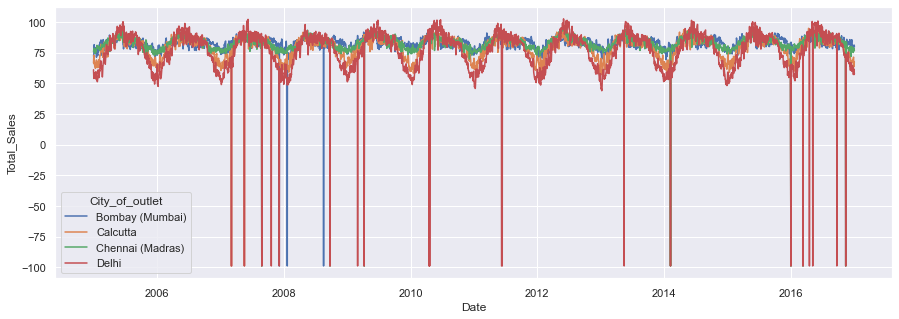

In [35]:
sns.set()
plt.figure(figsize=(15, 5))
sns.lineplot(data=data, y=data['Total_Sales'],
             x=data.index, hue='City_of_outlet')

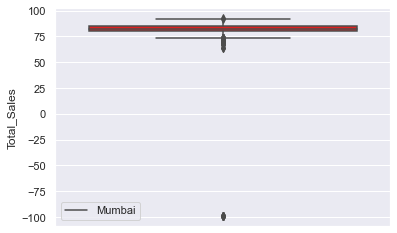

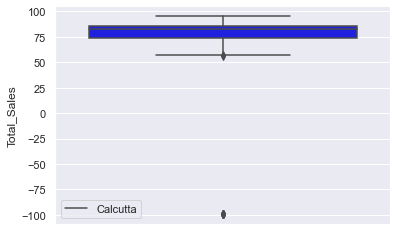

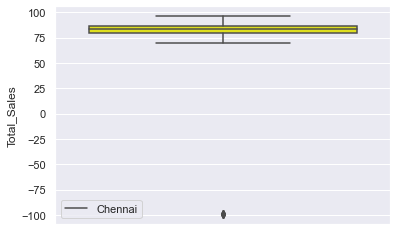

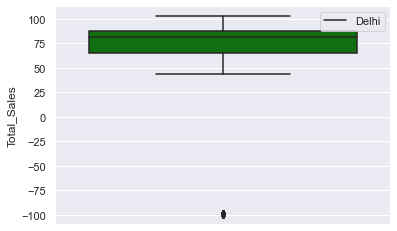

In [36]:
sns.boxplot(data=data[data.City_of_outlet ==
            'Bombay (Mumbai)'], y='Total_Sales', color='red')
plt.legend(['Mumbai'])
plt.show()
sns.boxplot(data=data[data.City_of_outlet == 'Calcutta'],
            y='Total_Sales', color='blue',)
plt.legend(['Calcutta'])
plt.show()
sns.boxplot(data=data[data.City_of_outlet ==
            'Chennai (Madras)'], y='Total_Sales', color='yellow',)
plt.legend(['Chennai'])
plt.show()
sns.boxplot(data=data[data.City_of_outlet == 'Delhi'],
            y='Total_Sales', color='green',)
plt.legend(['Delhi'])
plt.show()

#### Here the above line plot and box plot shows that there are some outliers in the data which are ranging till -100 so we need to get rid of those outliers.

In [37]:
data = data[data['Total_Sales'] > 0]

<AxesSubplot:xlabel='Date', ylabel='Total_Sales'>

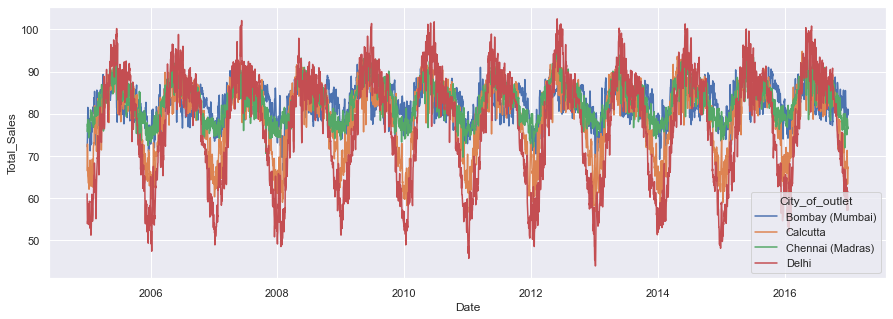

In [38]:
plt.figure(figsize=(15, 5))
sns.lineplot(data=data, y=data['Total_Sales'],
             x=data.index, hue='City_of_outlet',)

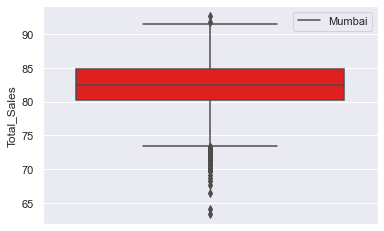

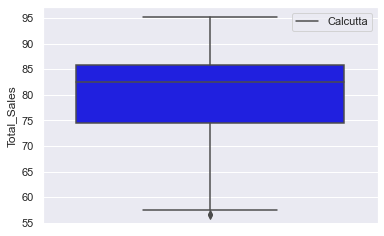

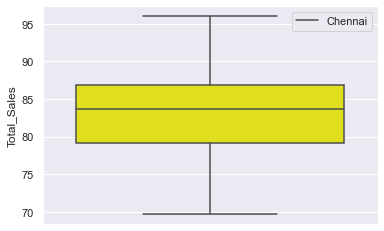

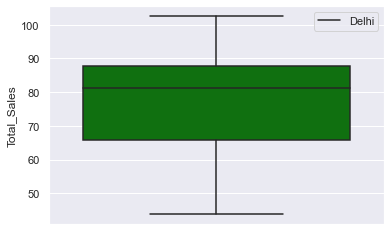

In [42]:
sns.boxplot(data=data[data.City_of_outlet ==
            'Bombay (Mumbai)'], y='Total_Sales', color='red')
plt.legend(['Mumbai'])
plt.show()
sns.boxplot(data=data[data.City_of_outlet == 'Calcutta'],
            y='Total_Sales', color='blue',)
plt.legend(['Calcutta'])
plt.show()
sns.boxplot(data=data[data.City_of_outlet ==
            'Chennai (Madras)'], y='Total_Sales', color='yellow',)
plt.legend(['Chennai'])
plt.show()
sns.boxplot(data=data[data.City_of_outlet == 'Delhi'],
            y='Total_Sales', color='green',)
plt.legend(['Delhi'])
plt.show()

#### Now here are no outliers and the whole data lies in a positive range. 

In [39]:
print('Mumbai:', len(data[data.City_of_outlet == 'Bombay (Mumbai)']))
print('Calcutta:', len(data[data.City_of_outlet == 'Calcutta']))
print('Chennai:', len(data[data.City_of_outlet == 'Chennai (Madras)']))
print('Delhi:', len(data[data.City_of_outlet == 'Delhi']))

Mumbai: 4373
Calcutta: 4373
Chennai: 4376
Delhi: 4357


In [40]:
# creating a dictionary for each city
dic_data = {'Mumbai': data[data.City_of_outlet == 'Bombay (Mumbai)'],
            'Calcutta': data[data.City_of_outlet == 'Calcutta'],
            'Chennai': data[data.City_of_outlet == 'Chennai (Madras)'],
            'Delhi': data[data.City_of_outlet == 'Delhi']
            }
dic_data['Mumbai']

,City_of_outlet,Total_Sales
Date,,
2005-01-01,Bombay (Mumbai),72.2
2005-01-02,Bombay (Mumbai),72.7
2005-01-03,Bombay (Mumbai),74.3
2005-01-04,Bombay (Mumbai),78.9
2005-01-05,Bombay (Mumbai),81.5
...,...,...
2016-12-27,Bombay (Mumbai),79.8
2016-12-28,Bombay (Mumbai),79.9
2016-12-29,Bombay (Mumbai),80.6


In [41]:
# dropping City_of_outlet column since the key value of dictionary specifies it
for city in dic_data.keys():
    dic_data[city].drop('City_of_outlet',axis=1,inplace=True)

dic_data['Mumbai']

,Total_Sales
Date,
2005-01-01,72.2
2005-01-02,72.7
2005-01-03,74.3
2005-01-04,78.9
2005-01-05,81.5
...,...
2016-12-27,79.8
2016-12-28,79.9
2016-12-29,80.6


### Splitting the data into train and validation set

In [68]:
# now performing time series lstm analysis for each city
dic_train={}
dic_val={}

for city in dic_data.keys():
    train_len=int(len(dic_data[city])*0.66)
    val_len=len(dic_data[city])-train_len
    dic_train[city]=dic_data[city].iloc[:train_len]
    dic_val[city]=dic_data[city].iloc[train_len:train_len+val_len]

print(dic_train['Calcutta'].tail())
dic_val['Calcutta'].head()

            Total_Sales
Date                   
2012-11-27         69.4
2012-11-28         67.7
2012-11-29         67.9
2012-11-30         68.4
2012-12-01         69.4


,Total_Sales
Date,
2012-12-02,68.4
2012-12-03,68.2
2012-12-04,69.3
2012-12-05,71.3
2012-12-06,68.6


In [69]:
dic_sc={}
dic_train_sc={}
dic_val_sc={}
for city in dic_train.keys():
    dic_sc[city]=MinMaxScaler(feature_range=(0,1))
    dic_train_sc[city]=dic_sc[city].fit_transform(dic_train[city])
    dic_val_sc[city]=dic_sc[city].transform(dic_val[city])

In [70]:
seq_size = length =  10 
batch_size = 1 
n_features=1  
dic_train_generator={}
dic_val_generator={}
for city in dic_train_sc.keys():
    dic_train_generator[city]=TimeseriesGenerator(dic_train_sc[city],dic_train_sc[city],
    length=length,batch_size=1)
    dic_val_generator[city]=TimeseriesGenerator(dic_val_sc[city],dic_val_sc[city],
    length=length,batch_size=1)

In [71]:
print('Samples in train data: %d' % len(dic_train_sc[city]))
print('Samples in train generator: %d' % len(dic_train_generator[city]))

Samples in train data: 2875
Samples in train generator: 2865


# 4. Model Building

In [72]:
dic_model={}
for city in dic_train_sc.keys():
    dic_model[city]=Sequential()
    dic_model[city].add(LSTM(units=64,activation='relu',input_shape=(seq_size,n_features),
        return_sequences=True))
    dic_model[city].add(LSTM(units=32,activation='relu',input_shape=(seq_size,n_features),
        return_sequences=False))
    dic_model[city].add(Dense(1)) # since output is 1
        
    dic_model[city].compile(optimizer='adam', loss='mean_squared_error')

dic_model['Delhi'].summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 10, 64)            16896     
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [73]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(length, n_features)))
model.add(LSTM(50, activation='relu'))
#model.add(Dense(32))
model.add(Dense(1))

In [74]:
for city in dic_train_sc.keys():
    dic_model[city].fit_generator(generator=dic_train_generator[city],
     epochs=10, validation_data=dic_val_generator[city])

C:\anaconda\envs\tensorflow\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
2876/2876 [==============================] - 38s 11ms/step - loss: 0.0088 - val_loss: 0.0078
Epoch 2/10
2876/2876 [==============================] - 33s 11ms/step - loss: 0.0048 - val_loss: 0.0034
Epoch 3/10
2876/2876 [==============================] - 33s 11ms/step - loss: 0.0036 - val_loss: 0.0054
Epoch 4/10
2876/2876 [==============================] - 33s 11ms/step - loss: 0.0036 - val_loss: 0.0049
Epoch 5/10
2876/2876 [==============================] - 33s 11ms/step - loss: 0.0034 - val_loss: 0.0045
Epoch 6/10
2876/2876 [==============================] - 33s 11ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 7/10
2876/2876 [==============================] - 33s 11ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 8/10
2876/2876 [==============================] - 33s 11ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 9/10
2876/2876 [==============================] - 33s 11ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 10/10
2876/2876 [==============================] - 32s 11m

# 5. Predicting Train and Validation data

In [75]:
dic_train_p={}
dic_val_p={}
for city in dic_train_sc.keys():
    dic_train_p[city]=dic_model[city].predict(dic_train_generator[city])
    dic_val_p[city]=dic_model[city].predict(dic_val_generator[city])

In [76]:
dic_train_p_inv={}
dic_val_p_inv={}

for city in dic_train_sc.keys():
    dic_train_p_inv[city] = dic_sc[city].inverse_transform(dic_train_p[city])
    # trainY_inverse = scaler.inverse_transform(train)
    dic_val_p_inv[city] = dic_sc[city].inverse_transform(dic_val_p[city])
    # testY_inverse = scaler.inverse_transform(test)

# 6. Calculating Root Mean Squared Error

In [77]:
dic_train_score={}
dic_val_score={}
for city in dic_train_sc.keys():
    dic_train_score[city] = math.sqrt(mse(dic_train_p_inv[city][:], dic_train[city].iloc[length:,0]))
    print('Train Score for %s : %.2f RMSE' % (city,dic_train_score[city]))

    dic_val_score[city] = math.sqrt(mse(dic_val_p_inv[city][:], dic_val[city].iloc[length:,0]))
    print('Validation Score for %s : %.2f RMSE' % (city,dic_val_score[city]))

Train Score for Mumbai : 1.55 RMSE
Validation Score for Mumbai : 1.55 RMSE
Train Score for Calcutta : 2.20 RMSE
Validation Score for Calcutta : 2.15 RMSE
Train Score for Chennai : 1.60 RMSE
Validation Score for Chennai : 1.60 RMSE
Train Score for Delhi : 2.63 RMSE
Validation Score for Delhi : 2.70 RMSE


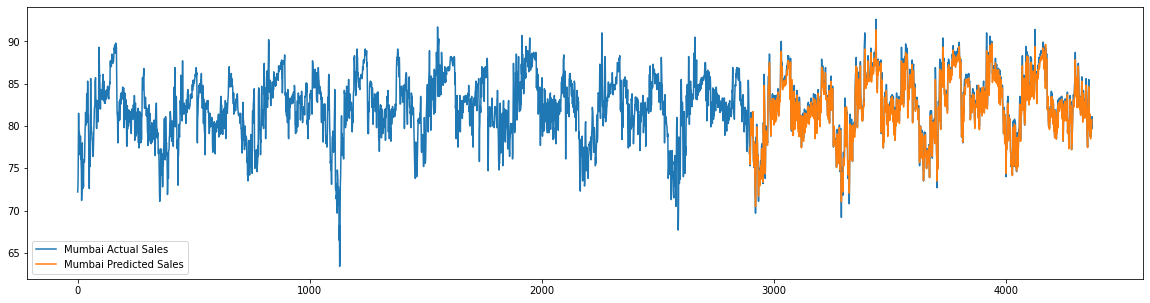

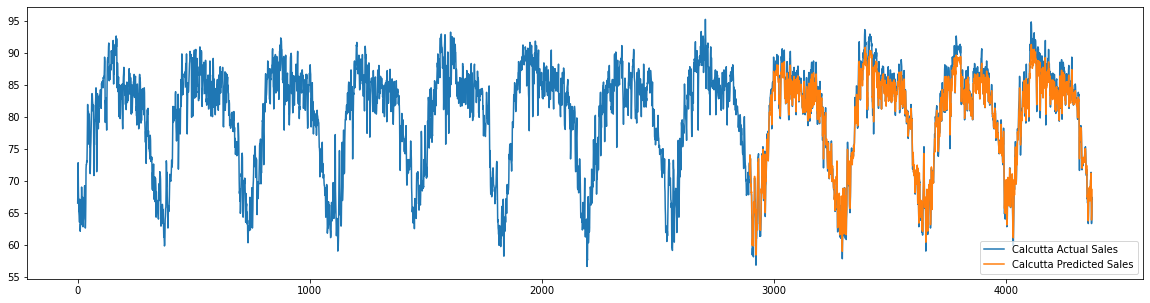

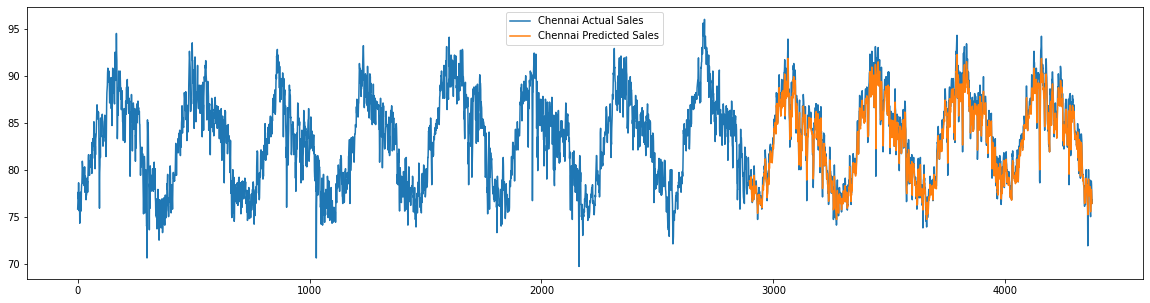

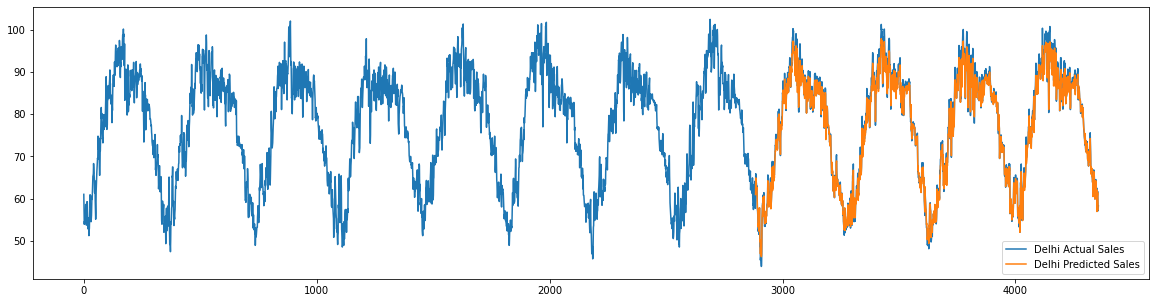

In [78]:
dic_val_pre_plot={}

for city in dic_train_sc.keys():
    dic_train_pre_plot[city] = np.empty_like(dic_data[city])
    dic_train_pre_plot[city][:, :] = np.nan
    dic_train_pre_plot[city][length:len(dic_train_p_inv[city])+length, :] = dic_train_p_inv[city][:]

    dic_val_pre_plot[city] = np.empty_like(dic_data[city])
    dic_val_pre_plot[city][:, :] = np.nan
    dic_val_pre_plot[city][len(dic_train[city])+(length)-1:len(dic_data[city])-1, :] = dic_val_p_inv[city][:]

    plt.figure(figsize=(20,5))
    plt.plot(dic_data[city].values,label=city+' Actual Sales')
    plt.plot(dic_val_pre_plot[city],label=city+' Predicted Sales')
    
    plt.legend()
    plt.show()

# forecasting sales
test_predictions={}

#### Above graphs show us the Actual and Predicted Sales in each city. 

# 7. Sales Forecasting

In [79]:
test_1_predictions={}
n_input=10
n_features=1
dic_test_generator={}
for city in dic_train_sc.keys():
    first_test_batch = dic_val_sc[city][-n_input-1:]
    test_1_predictions[city]=[]
    dic_test_generator[city]=TimeseriesGenerator(first_test_batch,first_test_batch,
    length=length,batch_size=1)
    for i in range(365*2):  
        pred = dic_model[city].predict(dic_test_generator[city])[0]
        test_1_predictions[city].append(pred)

        first_test_batch = np.append(first_test_batch[1:,:],[pred],axis=0)
        dic_test_generator[city]=TimeseriesGenerator(first_test_batch,first_test_batch,
        length=length,batch_size=1)

In [81]:
actual_predictions={}

for city in dic_train_sc.keys():
    actual_predictions[city]=dic_sc[city].inverse_transform(test_1_predictions[city])

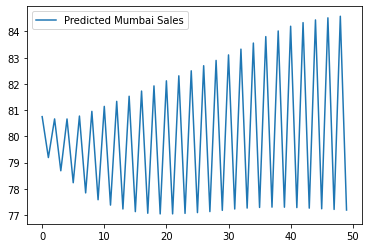

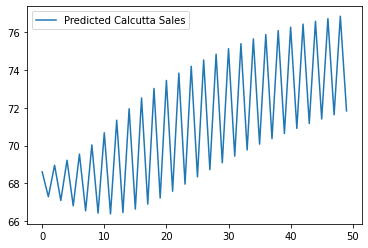

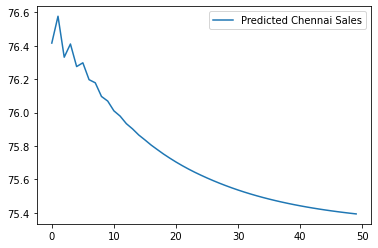

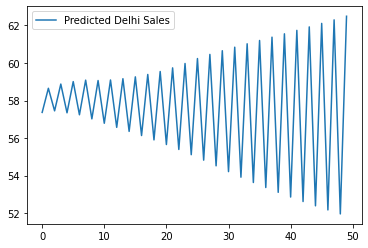

In [82]:
for city in dic_train_sc.keys():
    plt.plot(actual_predictions[city][:50],label='Predicted '+ city+ ' Sales')
    plt.legend()
    plt.show()

# 8. Conclusion 

Train Score for Mumbai : 1.55 RMSE    |  Validation Score for Mumbai : 1.55 RMSE
Train Score for Calcutta : 2.20 RMSE  |  Validation Score for Calcutta : 2.15 RMSE
Train Score for Chennai : 1.60 RMSE   |  Validation Score for Chennai : 1.60 RMSE
Train Score for Delhi : 2.63 RMSE     |  Validation Score for Delhi : 2.70 RMSE

1. Following are the Validation Score and Train Score for all the 4 cities, the score are predicted in RMSE values so all the values are good enough.
2. The above graphs shows the first 50 actual preditions of the sales.
3. The predicted sales for Mumbai forecasts the behaviour in Cyclic Manner, there is no trend but the graph is moving up and down after some intervals in Cyclic Pattern.
4. The Calcutta sales are also moving and down after some intervals which shows a Seasonal patter but they are showing some trend which is an upward trend. That means that Calcutta Sales are showing Seasonal Upward Trend
5. The predicted sales for Chennai is a downward trend and the sales are moving down in future.
6. The Delhi predicted sales are again showing a Cyclic Pattern and repeating upward and downward and growing as they are moving in future and spreading in a wide area. There is no Trend but we can conclude it with Seasonal Cyclic Pattern.
7. Hence following are the predictions made from above model.
8. These can be improved and more efficient model can be made and forecasting can be done much accurately, Following model is also making good predictions and accurate forecasting.